In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
df_10k = pd.read_csv ('10krace.csv')
secs = df_10k['secs'].tolist()
hr = df_10k['hr'].tolist()
speed_kph = df_10k['kph'].tolist()
df_10k.head()

,secs,cad,hr,km,kph,nm,watts,alt,lon,lat,...,interval,lrbalance,lte,rte,lps,rps,smo2,thb,o2hb,hhb
0,1,0,84,0.009918,35.7061,0,0,-1.80,54.347944,24.415457,...,0,-255,0,0,0,0,0,0,0,0
1,2,86,89,0.011877,29.9750,0,0,-1.64,54.347941,24.415474,...,0,-255,0,0,0,0,0,0,0,0
2,3,86,89,0.013835,24.2439,0,0,-1.48,54.347938,24.415492,...,0,-255,0,0,0,0,0,0,0,0
3,4,86,89,0.015794,18.5128,0,0,-1.32,54.347935,24.415509,...,0,-255,0,0,0,0,0,0,0,0
4,5,86,89,0.017752,12.7817,0,0,-1.16,54.347932,24.415527,...,0,-255,0,0,0,0,0,0,0,0


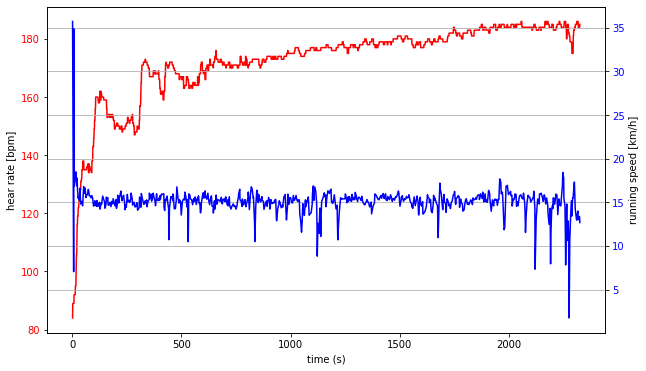

In [26]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1_color = 'red'
ax1.plot(secs,hr,color=ax1_color,label='heart rate')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('hear rate [bpm]')
ax1.tick_params(axis='y', labelcolor=ax1_color)

ax2 = ax1.twinx()
ax2_color = 'blue'
ax2.plot(secs,speed_kph,color=ax2_color,label='speed [km/h]')
ax2.set_ylabel('running speed [km/h]')
ax2.tick_params(axis='y', labelcolor=ax2_color)

plt.grid()

In [75]:
a1 = 1.84
a2 = 24.32
a3 = 6.36e-2
a4 = 3.21e-3
a5 = 12.81
speed = 1

x1_lim = 25
x2_lim = 0.05

def get_x1_dot(x1,x2,speed,a1,a2,a3,a4,a5):
    x1_dot = -a1*x1 + a2*(x2+speed**2)
    return x1_dot

def get_x2_dot(x1,x2,speed,a1,a2,a3,a4,a5):
    phi = a4*x1/(1+np.exp(-(x1-a5)))
    x2_dot = -a3*x2 + phi
    return x2_dot

x1 = np.linspace(0, x1_lim, 20)
x2 = np.linspace(0, x2_lim, 20)

X1, X2 = np.meshgrid(x1, x2)

t = 0

u, v = np.zeros(X1.shape), np.zeros(X2.shape)

NI, NJ = X1.shape

for i in range(NI):
    for j in range(NJ):
        x1 = X1[i, j]
        x2 = X2[i, j]
        x1_dot = get_x1_dot(x1,x2,speed,a1,a2,a3,a4,a5)
        x2_dot = get_x2_dot(x1,x2,speed,a1,a2,a3,a4,a5)
        u[i,j] = x1_dot
        v[i,j] = x2_dot

In [76]:
def sys(x1_0, x2_0, dt, time):
    x1,x2=[],[]
    # initial values:
    x1.append(x1_0)
    x2.append(x2_0)
    for i in range(time):
        x1.append(x1[-1] + (get_x1_dot(x1[-1],x2[-1],speed,a1,a2,a3,a4,a5)) * dt)
        x2.append(x2[-1] + (get_x2_dot(x1[-1],x2[-1],speed,a1,a2,a3,a4,a5)) * dt)
    return x1, x2

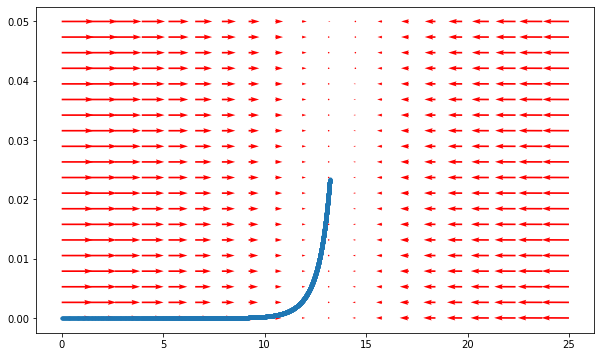

In [77]:
max_t = secs[-1]
dt = 0.001
resting_HR = 80
x1_0 = 0 #initially, the difference HR and resting HR is 0, obviously
x2_0 = 0

plt.figure(figsize=(10, 6))
Q = plt.quiver(X1, X2, u, v, color='r')

[x1,x2] = sys(x1_0, x2_0, dt, max_t)
plt.plot(x1,x2,'.')

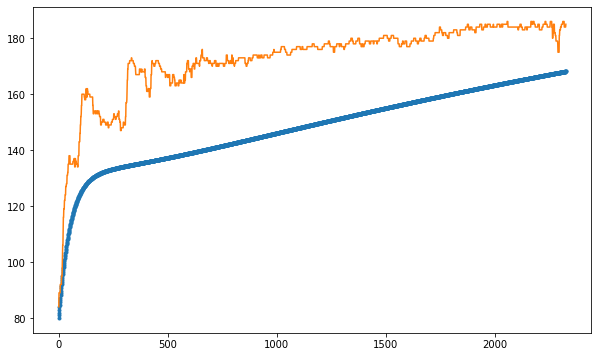

In [59]:
plt.figure(figsize=(10, 6))
time = np.linspace(0,max_t,len(x1))
[x1,x2] = sys(x1_0, x2_0, dt*10, max_t)
HR = 4*np.array(x1) + resting_HR
plt.plot(time,HR,'.')
plt.plot(secs,hr)